# <font color='dodgerblue'>Twitter Insight Engine

### <font color='orange'>1. Problem Defining
### <font color='orange'>2. Features and Distributions: Target Distribution, Word Count..
### <font color='orange'>3. Data Cleaning: Stopwords, Contraction, Ngrams, WordCloud
> raw text corpus -> processing text -> tokenized text -> corpus vocabulary -> text representation 
### <font color='orange'>4. Models: GLoVe, LSTM, Bert

## 1. Problem Defining:

### - Social media platforms and the communications happen on them are changing our society. 
### - NLP methods will be used in this project to predict if a tweet is about a disaster or not.



###  <font color='green'>2022 Survey of Natural language processing (NLP) methods

   1. Word embeddings/vectors (GLoVe, fastText, word2vec) 
   2. Transformer language models (GPT-3, BERT, XLnet, etc)
   3. Encoder-decoder models (seq2seq, vanilla transformers)
   4. Contextualized embeddings (ELMo, CoVe)


In [1]:
#python basics
from matplotlib import pyplot as plt
import math, os, re, time, random, string
import numpy as np, pandas as pd, seaborn as sns

from tqdm import tqdm
import matplotlib.pyplot as plt
plt.style.use('ggplot')   
import seaborn as sns

from collections import defaultdict
import wordcloud
import tensorflow as tf

In [2]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(14)

import warnings
warnings.filterwarnings('ignore')

# 2. Features and Distributions

In [6]:
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


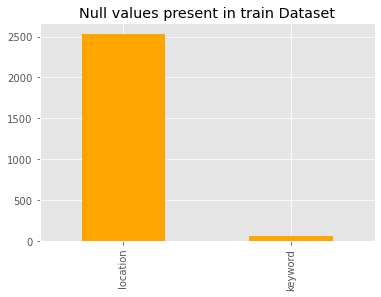

In [8]:
missing = train.isnull().sum()  
missing[missing>0].sort_values(ascending=False).plot(kind='bar',title='Null values present in train Dataset', color=['orange'])

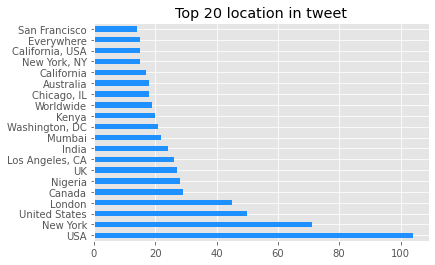

In [14]:
train.location.value_counts()[:20].plot(kind='barh', title='Top 20 location in tweet', color='dodgerblue') 

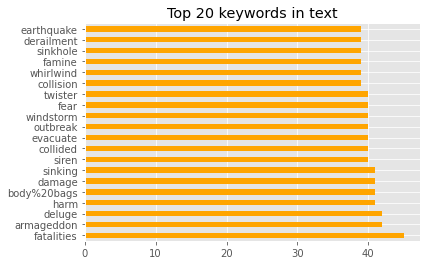

In [11]:
train.keyword.value_counts()[:20].plot(kind='barh', title='Top 20 keywords in text', color='orange')

In [4]:
#save ID
test_id = test['id']

#drop from train and test
columns = {'id', 'location'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

#fill missing with unknown
train['keyword'] = train['keyword'].fillna('unknown')
test['keyword'] = test['keyword'].fillna('unknown')

#add keyword to tweets
train['text'] = train['text'] + ' ' + train['keyword']
test['text'] = test['text'] + ' ' + test['keyword']

#drop fkeyword rom train and test
columns = {'keyword'}
train = train.drop(columns = columns)
test = test.drop(columns = columns)

total = train.append(test)

In [5]:
print('There are', len(train), 'rows in the train set')
print('There are', len(test), 'rows in the test set')

There are 7613 rows in the train set
There are 3263 rows in the test set


# Target Distribution

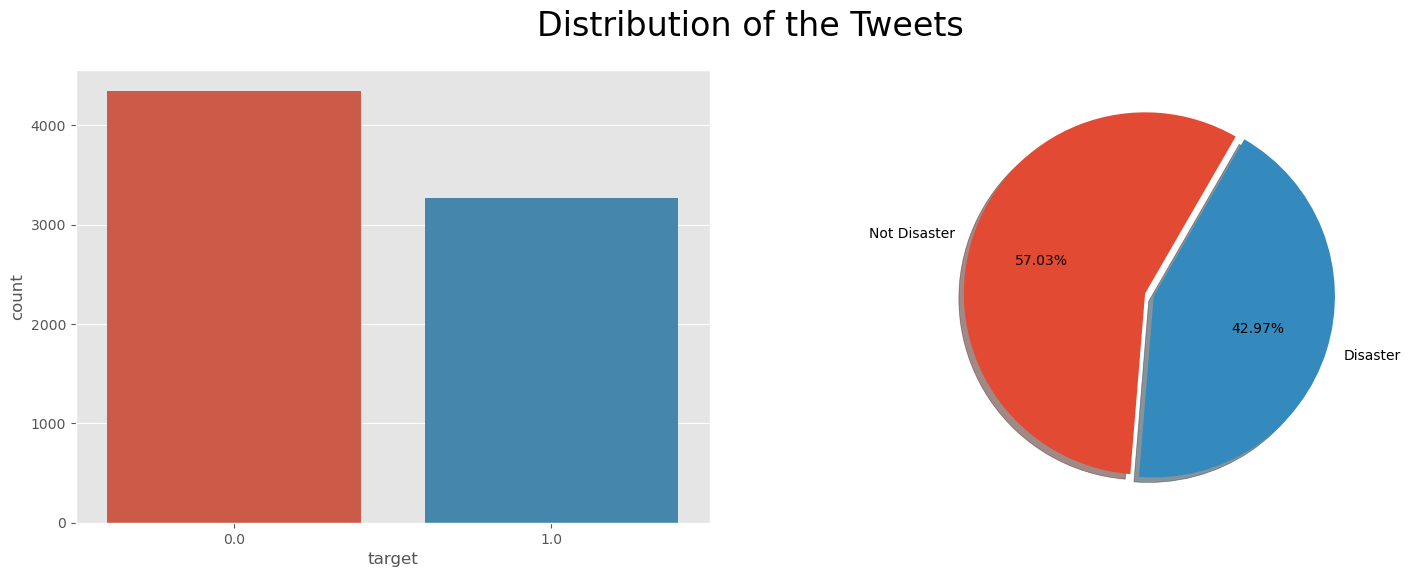

In [106]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(18, 6), dpi=100)
sns.countplot(train['target'], ax=axes[0])
axes[1].pie(train['target'].value_counts(),
            labels=['Not Disaster', 'Disaster'],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

## Word Count, Word Length, Character Counts etc.

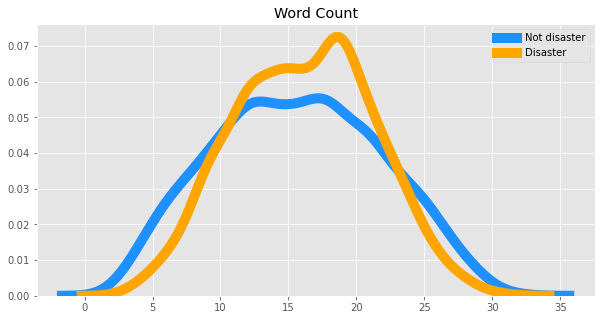

In [17]:
#create column for the number of words in tweet
total['word count'] = total['text'].apply(lambda x: len(x.split()))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['word count'][train['target'] == 0], lw=10,color = 'dodgerblue', label = 'Not disaster')
sns.kdeplot(train['word count'][train['target'] == 1], lw=10,color = 'orange', label = 'Disaster')

#set title and plot
plt.title('Word Count')
plt.show()

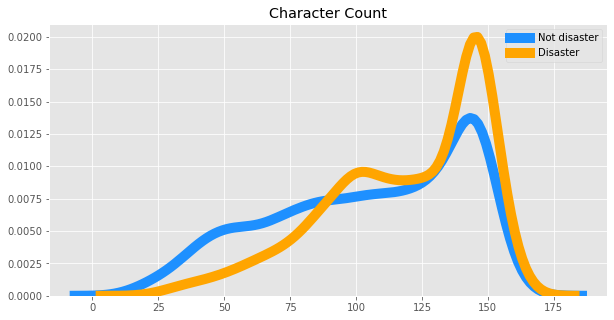

In [26]:
#create column for the number of characters in a tweet
total['character count'] = total['text'].apply(lambda x: len(x))

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['character count'][train['target'] == 0],lw=10, color = 'dodgerblue', label = 'Not disaster')
sns.kdeplot(train['character count'][train['target'] == 1],lw=10, color = 'orange', label = 'Disaster')

#set title and plot
plt.title('Character Count')
plt.show()

### larger part of disaster tweets > 100 characters 

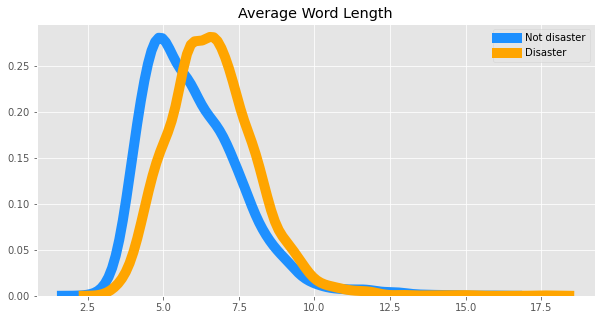

In [25]:
#define function to find average word length 
def average_word_length(x):
    x = x.split()
    return np.mean([len(i) for i in x])

#broadcast to text column
total['average word length'] = total['text'].apply(average_word_length)

#split so we can use updated train set with new feature
train = total[:len(train)]

#define subplot to see graphs side by side
fig, ax = plt.subplots(figsize = (10, 5))

#create graphs
sns.kdeplot(train['average word length'][train['target'] == 0], lw=10,color = 'dodgerblue', label = 'Not disaster')
sns.kdeplot(train['average word length'][train['target'] == 1], lw=10,color = 'orange', label = 'Disaster')

#set title
plt.title('Average Word Length')

#splot graphs
plt.show()

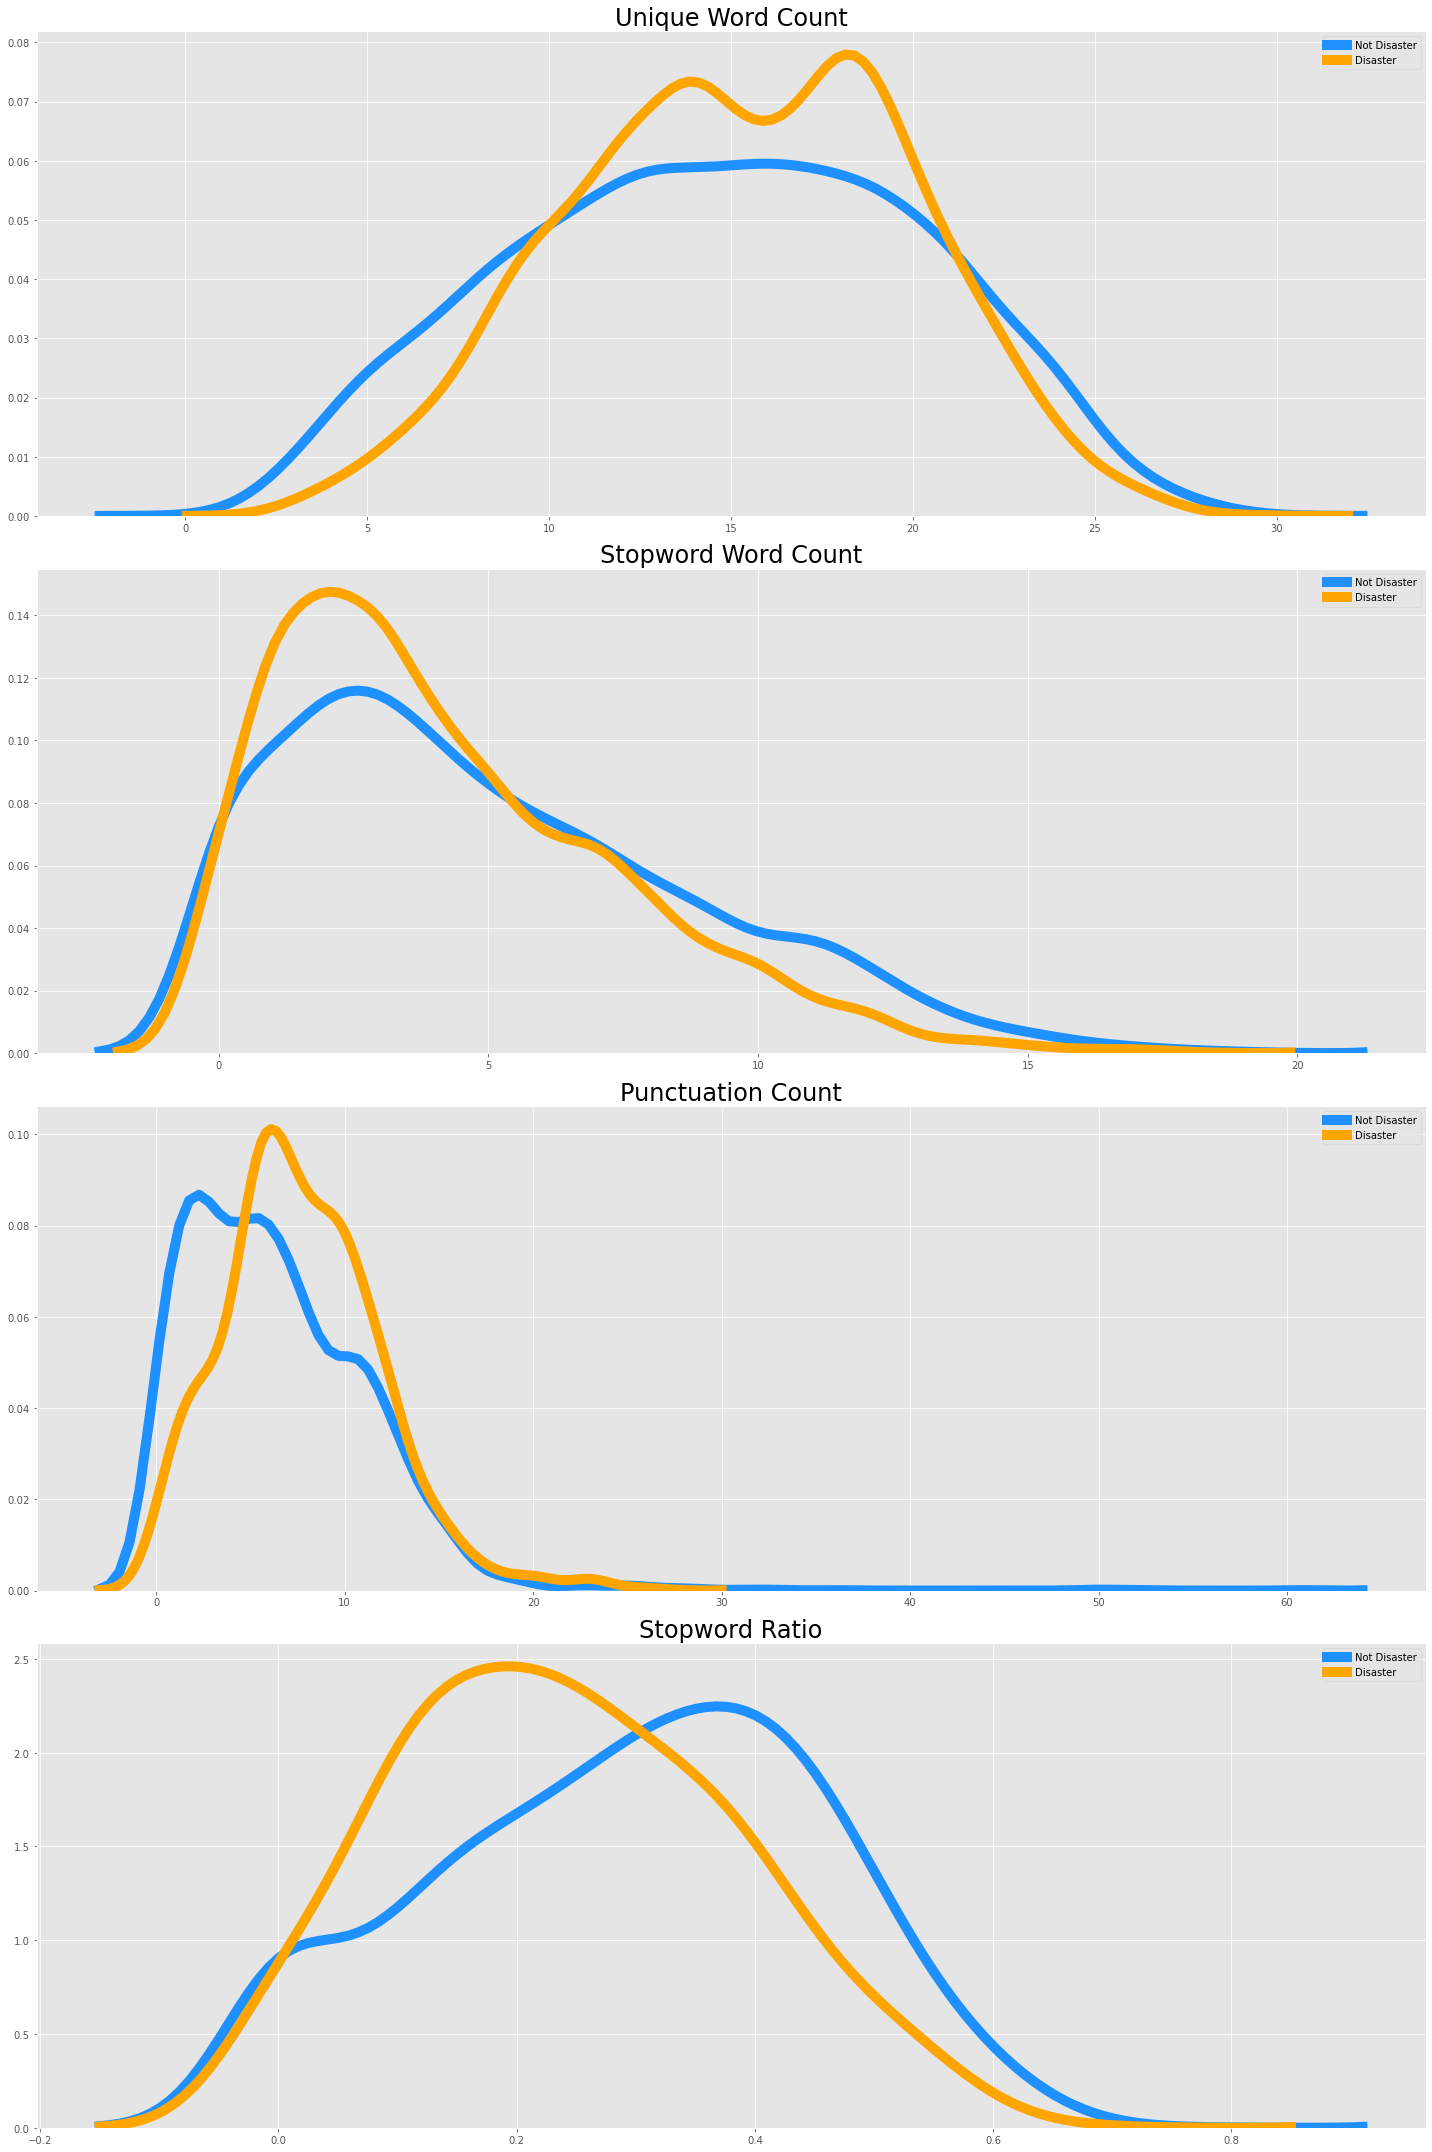

In [27]:
#add unique word count
total['unique word count'] = total['text'].apply(lambda x: len(set(x.split())))

#add stopword count
total['stopword count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if i in wordcloud.STOPWORDS]))

#add url count
#total['url count'] = total['text'].apply(lambda x: len([i for i in x.lower().split() if 'http' in i or 'https' in i]))

#add mention count
#total['mention count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '@']))

#add hashtag count
#total['hashtag count'] = total['text'].apply(lambda x: len([i for i in str(x) if i == '#']))

#add stopword ratio
total['stopword ratio'] = total['stopword count'] / total['word count']

#add punctuation count
total['punctuation count'] = total['text'].apply(lambda x: len([i for i in str(x) if i in string.punctuation]))

#split so we can use updated train set
train = total[:len(train)]

disaster = train['target'] == 1

#produce graphs to visualize newly added features
fig, axes = plt.subplots(4, figsize=(20, 30))

graph1 = sns.kdeplot(train.loc[~disaster]['unique word count'], lw=10,color = 'dodgerblue',  label = 'Not Disaster', ax=axes[0])
graph1 = sns.kdeplot(train.loc[disaster]['unique word count'], lw=10,color = 'orange',  label = 'Disaster', ax=axes[0])
graph1.set_title('Unique Word Count',fontsize=24)

graph2 = sns.kdeplot(train.loc[~disaster]['stopword count'], lw=10,color = 'dodgerblue',  label = 'Not Disaster', ax=axes[1])
graph2 = sns.kdeplot(train.loc[disaster]['stopword count'], lw=10,color = 'orange',  label = 'Disaster', ax=axes[1])
graph2.set_title('Stopword Word Count',fontsize=24)

graph3 = sns.kdeplot(train.loc[~disaster]['punctuation count'], lw=10,color = 'dodgerblue', label = 'Not Disaster', ax=axes[2], bw = 1)
graph3 = sns.kdeplot(train.loc[disaster]['punctuation count'], lw=10,color = 'orange',  label = 'Disaster', ax=axes[2], bw = 1)
graph3.set_title('Punctuation Count',fontsize=24)

graph4 = sns.kdeplot(train.loc[~disaster]['stopword ratio'],lw=10,color = 'dodgerblue',  label = 'Not Disaster', ax=axes[3], bw = .05)
graph4 = sns.kdeplot(train.loc[disaster]['stopword ratio'], lw=10,color = 'orange',  label = 'Disaster', ax=axes[3], bw = .05)
graph4.set_title('Stopword Ratio',fontsize=24)

fig.tight_layout()
plt.show()

# 3. Data Cleaning


> raw text corpus -> processing text -> tokenized text -> corpus vocabulary -> text representation 

In [29]:
#remove punctuation
def remove_punctuation(x):
    return x.translate(str.maketrans('', '', string.punctuation))

#remove stopwords
def remove_stopwords(x):
    return ' '.join([i for i in x.split() if i not in wordcloud.STOPWORDS])

#remove words less than 4 
def remove_less_than(x):
    return ' '.join([i for i in x.split() if len(i) > 3])

#remove words with non-alphabet characters
def remove_non_alphabet(x):
    return ' '.join([i for i in x.split() if i.isalpha()])

def strip_all_entities(x):
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x).split())

In [30]:
#check strip_all_entities functionality
strip_all_entities('@shawn Titanic #tragedy could have been prevented Economic \
                   Times: Telegraph.co.ukTitanic tragedy could have been preve... http://bet.ly/tuN2wx')

'Titanic tragedy could have been prevented Economic Times Telegraph co ukTitanic tragedy could have been preve'

In [31]:
#install autocorrect
!pip install autocorrect
from autocorrect import Speller 

#create function to spell check strings
def spell_check(x):
    spell = Speller(lang='en')
    return " ".join([spell(i) for i in x.split()])

#showcase spellcheck 
mispelled = 'Pleaze spelcheck this sentince'
spell_check(mispelled)

     |████████████████████████████████| 622 kB 577 kB/s eta 0:00:01
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622380 sha256=3412e7cdc58e9bc1328a85ddcd15461cfa76187603e067a0f4601e785e13e29c
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
Successfully built autocorrect
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


'Please spelcheck this sentence'

In [32]:
PROCESS_TWEETS = False
if PROCESS_TWEETS:
    #apply all of above functions
    total['text'] = total['text'].apply(lambda x: x.lower())
    total['text'] = total['text'].apply(lambda x: re.sub(r'https?://\S+|www\.\S+', '', x, flags = re.MULTILINE))
    total['text'] = total['text'].apply(remove_punctuation)
    total['text'] = total['text'].apply(remove_stopwords)
    total['text'] = total['text'].apply(remove_less_than)
    total['text'] = total['text'].apply(remove_non_alphabet)
    total['text'] = total['text'].apply(spell_check)

### expand contractions 

https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

In [33]:
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions.keys()))
def expand_contractions(s, contractions = contractions):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, s)

expand_contractions("can't stop won't stop")

'cannot stop will not stop'

In [34]:
#apply to whole text column
total['text'] = total['text'].apply(expand_contractions)

**queries to view hashtags, mispellings, etc.

In [35]:
 def clean(tweet):

    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    return tweet

total['text'] = total['text'].apply(clean)

## N-Gram Analysis

In [36]:
tweets = [tweet for tweet in total['text']]

#split data to update changes
train = total[:len(train)]
test = total[len(train):]

In [37]:
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in wordcloud.STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]

disaster_unigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        disaster_unigrams[word] += 1
disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_unigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 1):
        nondisaster_unigrams[word] += 1
nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])

disaster_bigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        disaster_bigrams[word] += 1
disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_bigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 2):
        nondisaster_bigrams[word] += 1
nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])

disaster_trigrams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        disaster_trigrams[word] += 1
disaster_trigrams = pd.DataFrame(sorted(disaster_trigrams.items(), key=lambda x: x[1])[::-1])

nondisaster_trigrams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 3):
        nondisaster_trigrams[word] += 1
nondisaster_trigrams = pd.DataFrame(sorted(nondisaster_trigrams.items(), key=lambda x: x[1])[::-1])


disaster_4grams = defaultdict(int)
for word in total[train['target'] == 1]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        disaster_4grams[word] += 1
disaster_4grams = pd.DataFrame(sorted(disaster_4grams.items(), key=lambda x: x[1])[::-1])

nondisaster_4grams = defaultdict(int)
for word in total[train['target'] == 0]['text']:
    for word in generate_ngrams(word, n_gram = 4):
        nondisaster_4grams[word] += 1
nondisaster_4grams = pd.DataFrame(sorted(nondisaster_4grams.items(), key=lambda x: x[1])[::-1])

# frequent unigrams: <font color='orange'>Disaster <font color='dodgerblue'>/ Not

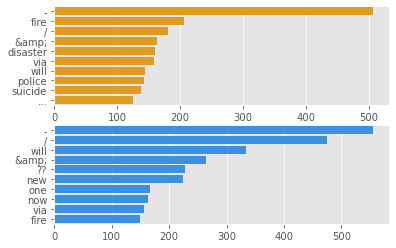

In [53]:
fig, ax = plt.subplots(2, 1)
sns.barplot(y = disaster_unigrams[0].values[:N], x = disaster_unigrams[1].values[:N], ax = ax[0], color='orange')
sns.barplot(y = nondisaster_unigrams[0].values[:N], x = nondisaster_unigrams[1].values[:N], ax = ax[1], color = 'dodgerblue')

# frequent bigrams: <font color='orange'>Disaster <font color='dodgerblue'>/ Not

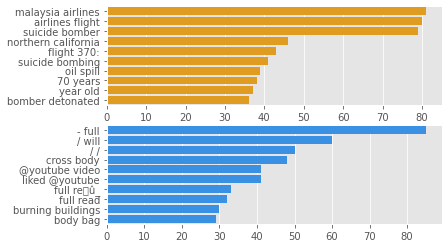

In [55]:
fig, ax = plt.subplots(2, 1)
sns.barplot(y = disaster_bigrams[0].values[:N], x = disaster_bigrams[1].values[:N], ax = ax[0], color='orange')
sns.barplot(y = nondisaster_bigrams[0].values[:N], x = nondisaster_bigrams[1].values[:N], ax = ax[1], color = 'dodgerblue')

# frequent trigrams: <font color='orange'>Disaster <font color='dodgerblue'>/ Not

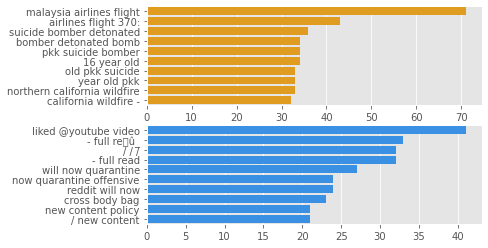

In [56]:
fig, ax = plt.subplots(2, 1)
sns.barplot(y = disaster_trigrams[0].values[:N], x = disaster_trigrams[1].values[:N], ax = ax[0], color='orange')
sns.barplot(y = nondisaster_trigrams[0].values[:N], x = nondisaster_trigrams[1].values[:N], ax = ax[1], color = 'dodgerblue')

# frequent 4grams: <font color='orange'>Disaster <font color='dodgerblue'>/ Not

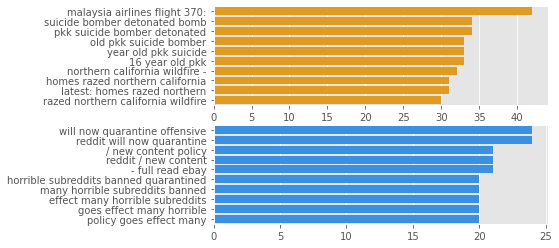

In [57]:
fig, ax = plt.subplots(2, 1)
sns.barplot(y = disaster_4grams[0].values[:N], x = disaster_4grams[1].values[:N], ax = ax[0], color='orange')
sns.barplot(y = nondisaster_4grams[0].values[:N], x = nondisaster_4grams[1].values[:N], ax = ax[1], color = 'dodgerblue')

# Worldcloud

In [73]:
from PIL import Image
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Choose Mask

In [79]:

mask = np.array(Image.open('/kaggle/input/wordcloud-mask/Twitter_bird_logo.png'))
mask[mask.sum(axis=2) == 0] = 255

In [86]:
stop = set(stopwords.words('english'))

trainv = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
testv = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)


def remove_emoji(text):
    emoji_pattern = re.compile(
        '['
        u'\U0001F600-\U0001F64F'  # emoticons
        u'\U0001F300-\U0001F5FF'  # symbols & pictographs
        u'\U0001F680-\U0001F6FF'  # transport & map symbols
        u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
        u'\U00002702-\U000027B0'
        u'\U000024C2-\U0001F251'
        ']+',
        flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)


def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
    return re.sub(html, '', text)


def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

# Applying helper functions

trainv['text_clean'] = trainv['text'].apply(lambda x: remove_URL(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_emoji(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_html(x))
trainv['text_clean'] = trainv['text_clean'].apply(lambda x: remove_punct(x))

trainv['tokenized'] = trainv['text_clean'].apply(word_tokenize)
trainv['lower'] = trainv['tokenized'].apply(
    lambda x: [word.lower() for word in x])
trainv['stopwords_removed'] = trainv['lower'].apply(
    lambda x: [word for word in x if word not in stop])
trainv['pos_tags'] = trainv['stopwords_removed'].apply(nltk.tag.pos_tag)
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


trainv['wordnet_pos'] = trainv['pos_tags'].apply(
    lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wnl = WordNetLemmatizer()

trainv['lemmatized'] = trainv['wordnet_pos'].apply(
    lambda x: [wnl.lemmatize(word, tag) for word, tag in x])

trainv['lemmatized'] = trainv['lemmatized'].apply(
    lambda x: [word for word in x if word not in stop])

trainv['lemma_str'] = [' '.join(map(str, l)) for l in trainv['lemmatized']]

### Define a plot function

In [87]:
def plot_wordcloud(text, title, title_size):
    """ A function for creating wordcloud images """
    words = text
    allwords = []
    for wordlist in words:
        allwords += wordlist
    mostcommon = FreqDist(allwords).most_common(140)
    wordcloud = WordCloud(
        width=1000,
        height=500,
        background_color='dodgerblue',
        stopwords=set(STOPWORDS),
        max_words=150,
        scale=3,
        mask=mask,
        contour_width=0.1,
        contour_color='white',
    ).generate(str(mostcommon))    

    def grey_color_func(word,
                        font_size,
                        position,
                        orientation,
                        random_state=None,
                        **kwargs):
        # A definition for creating grey color shades.
        return 'hsl(0, 0%%, %d%%)' % random.randint(60, 100)

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=42),
               interpolation='bilinear')
    plt.axis('off')
    plt.title(title,
              fontdict={
                  'size': title_size,
                  'verticalalignment': 'bottom'
              })
    plt.tight_layout(pad=0)
    plt.show()

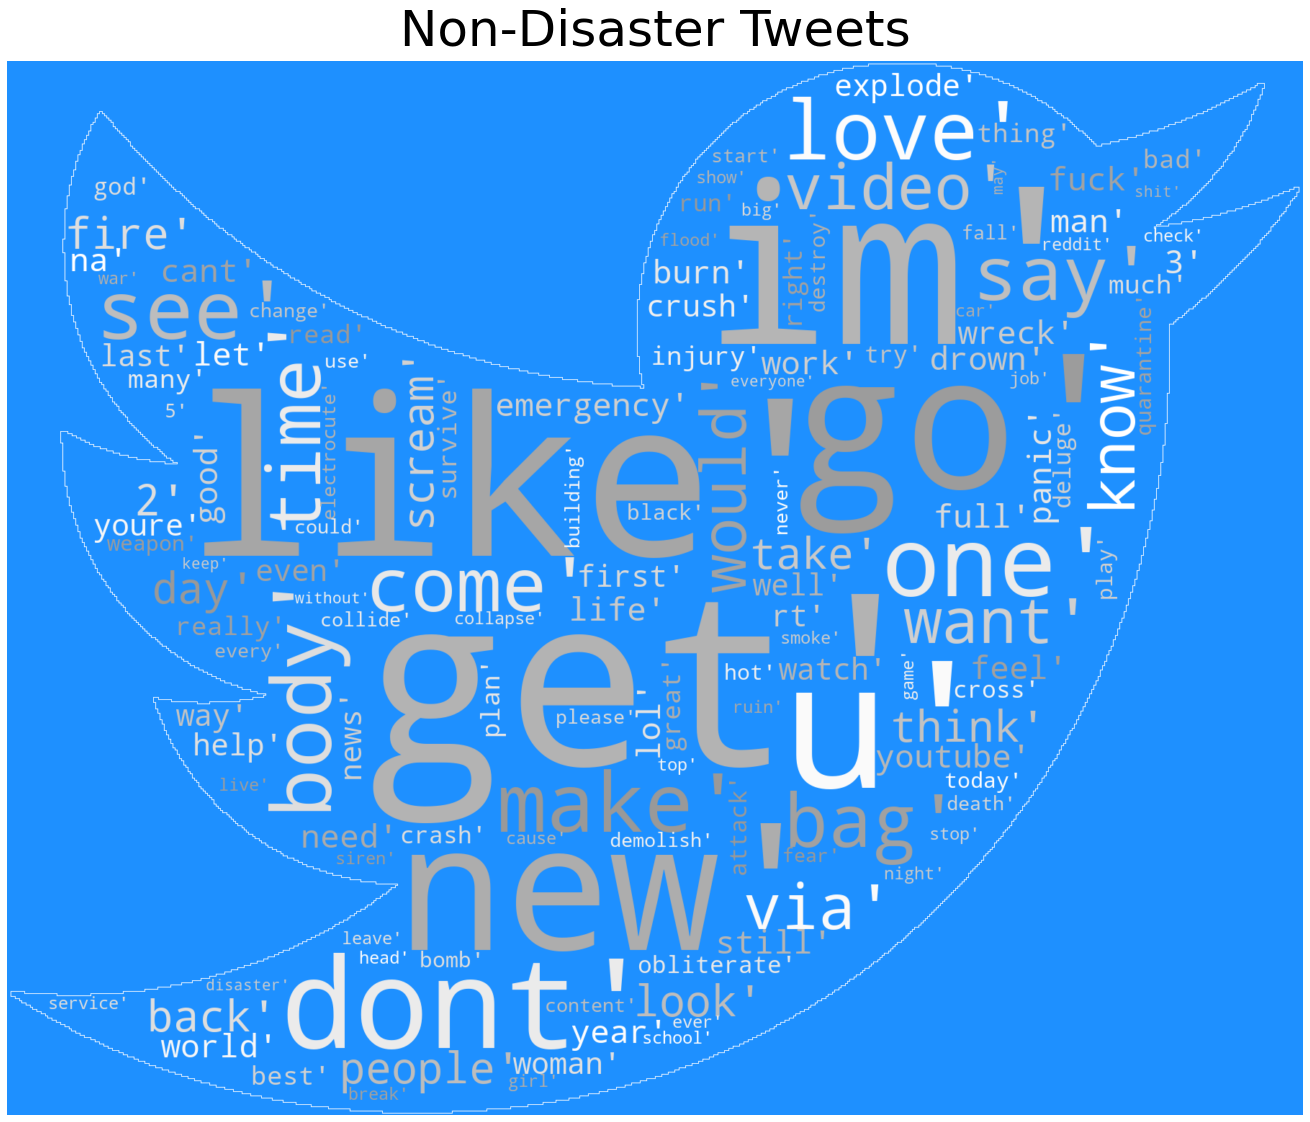

In [88]:
plot_wordcloud(trainv[trainv['target'] == 0]['lemmatized'],
               'Non-Disaster Tweets',
               title_size=50)

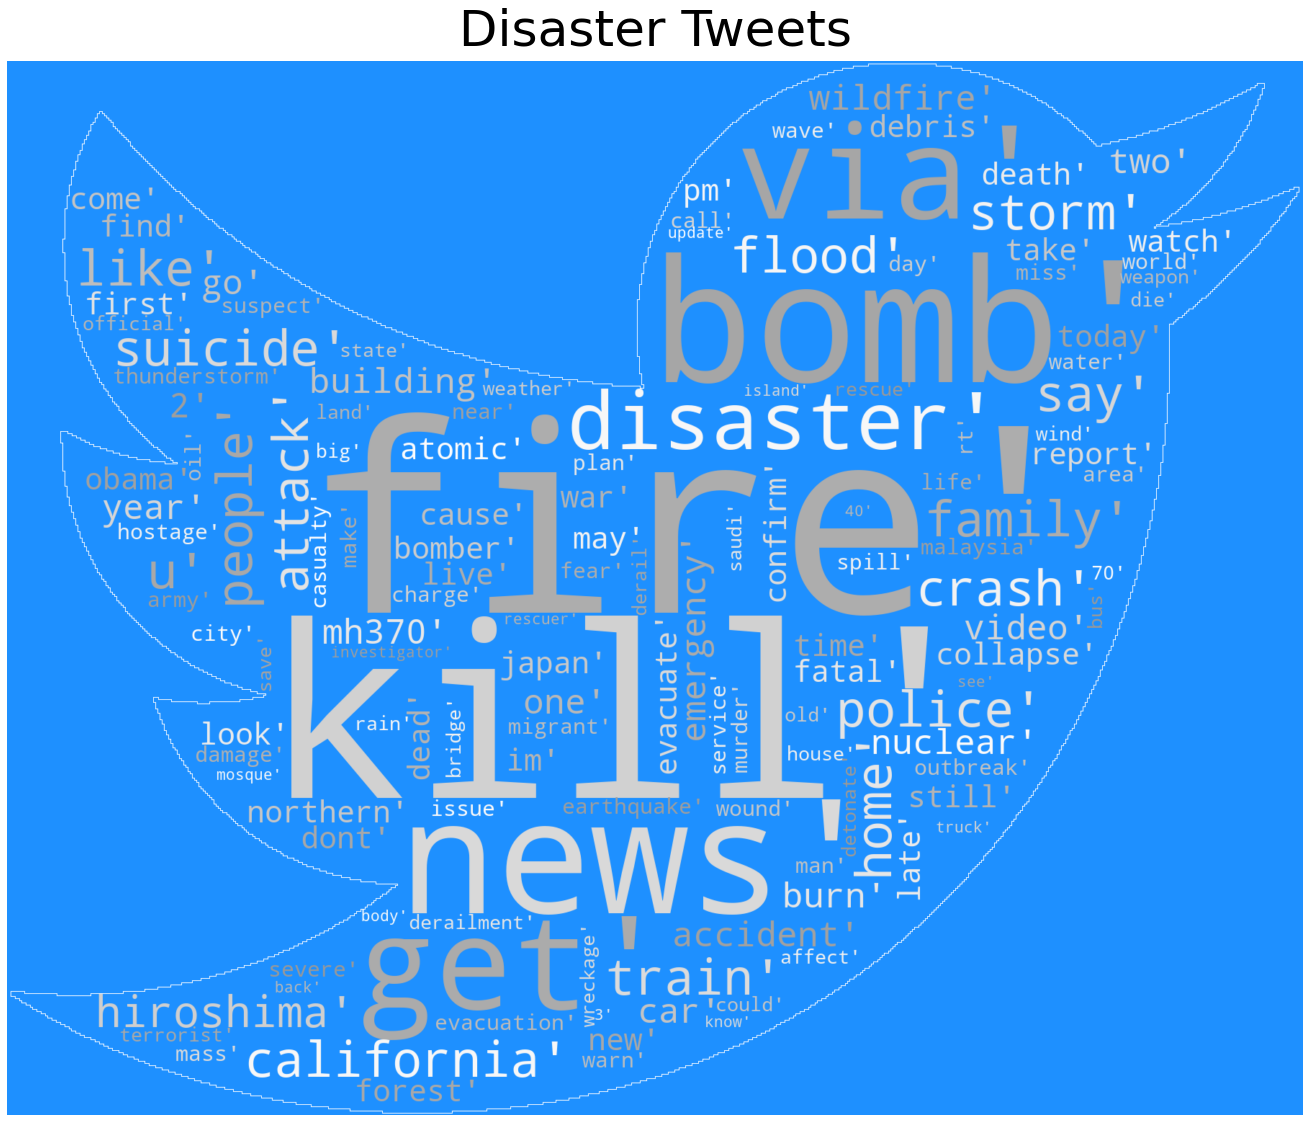

In [112]:
plot_wordcloud(trainv[trainv['target'] == 1]['lemmatized'],
               'Disaster Tweets',
               title_size=50)

# 4. Models

recurrent 'shallow' networks LSTMs
[BERT](https://arxiv.org/abs/1810.04805) 

embeddings: https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html**

instead of following the Bag of Word approach, we will import the pre-trained words from GloVe and use them to construct our word embeddings.

"GloVe is an unsupervised learning algorithm for obtaining vector representations for words. Training is performed on aggregated global word-word co-occurrence statistics from a corpus, and the resulting representations showcase interesting linear substructures of the word vector space."

some of the GloVe embeddings actually have tokens for punctuation

In [ ]:
from keras.preprocessing.text import Tokenizer

#find way to tokenize punctuation
to_exclude = '*+-/()%\n[\\]{|}^_`~\t'
to_tokenize = '!"#$&?:;<=>@'
tokenizer = Tokenizer(filters = to_exclude)


text = ''
text = re.sub(r'(['+to_tokenize+'])', r' \1 ', text)
tokenizer.fit_on_texts([text])

#view new text
print(tokenizer.word_index)

 using non-punctuation embedding for this notebook

In [22]:
#broadcast to entire text column
#total['text'] = total['text'].apply(lambda x: re.sub(r'(['+to_tokenize+'])', r' \1 ', x))

`oov_token` parameter in the Keras Tokenizer object 

when the tokenizer finds words that is out of vocabulary in the test set, instead of skipping them, it includes them as a token of our choosing

In [23]:
from keras.preprocessing.sequence import pad_sequences
from keras import Input

#define tokenizer options
tokenizer = Tokenizer()     
#tokenizer = Tokenizer(oov_token = '<OOV>')           #if you wanted to tokenized OOV words
#tokenizer = Tokenizer(filters = to_exclude)          #if you wanted to include punctuation
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences)
labels = train['target']
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

nlp_train = data[:len(train)]
labels = labels
nlp_test = data[len(train):]

MAX_SEQUENCE_LENGTH = data.shape[1]

Found 29279 unique tokens.
Shape of data tensor: (10876, 40)
Shape of label tensor: (7613,)


will try both Wikipedia (400k words) and Twitter (1000k) based embeddings, typically using the higher dimensional representations, either 200D or 300D**

 https://nlp.stanford.edu/projects/glove/

In [24]:
#get GloVe vector embeddings
embeddings_index = {}
with open('../input/glove-global-vectors-for-word-representation/glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors in the GloVe library' % len(embeddings_index))

400000it [00:23, 16958.14it/s]

Found 400000 word vectors in the GloVe library


In [25]:
EMBEDDING_DIM = 200   #defined by size of GloVe word vector dimensions

In [26]:
#initialize embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))

#add glove word encodings to our library
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        
        #words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
print("Our embedded matrix is of dimension", embedding_matrix.shape)

100%|██████████| 29279/29279 [00:00<00:00, 430209.51it/s]

Our embedded matrix is of dimension (29280, 200)


In [27]:
#import neural network basic
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Dropout, Concatenate, LeakyReLU, GRU
from keras import Input, Model, regularizers
from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping

embedding = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights = [embedding_matrix],
                     input_length = MAX_SEQUENCE_LENGTH, trainable = False)  

#we do not want embedding layer to train since it has been pretrained

### Scaling

In [28]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def scale(df, scaler):
    return scaler.fit_transform(df.iloc[:, 2:])

#and scal
meta_train = scale(train, StandardScaler())
meta_test = scale(test, StandardScaler())

## Simple LSTM Model

 https://www.youtube.com/watch?v=SEnXr6v2ifU

dropouts and a regularizer to control overfitting

 https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
 
 https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/  
 
https://machinelearningmastery.com/use-weight-regularization-lstm-networks-time-series-forecasting/

In [29]:
#function to create lstm model
def create_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)        
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [30]:
#define conveient training function to visualize learning curves
def plot_learning_curves(history): 
    fig, ax = plt.subplots(1, 2, figsize = (20, 10))

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])

    ax[0].legend(['train', 'validation'], loc = 'upper left')
    ax[1].legend(['train', 'validation'], loc = 'upper left')

    fig.suptitle("Model Accuracy", fontsize=14)

    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')

    return plt.show()

In [31]:
#create our first model
lstm = create_lstm(spatial_dropout = .2, dropout = .2, recurrent_dropout = .2,
                     learning_rate = 3e-4, bidirectional = True)
lstm.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 200)      5856000     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 40, 200)      0           embedding_1[0][0]                
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 200)          240800      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [32]:
#fit model
history1 = lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 5, batch_size = 21, verbose = 1)

Train on 6090 samples, validate on 1523 samples
Epoch 1/5
6090/6090 [==============================] - 44s 7ms/step - loss: 0.5343 - accuracy: 0.7384 - val_loss: 0.4363 - val_accuracy: 0.7965
Epoch 2/5
6090/6090 [==============================] - 43s 7ms/step - loss: 0.4645 - accuracy: 0.7874 - val_loss: 0.4238 - val_accuracy: 0.7991
Epoch 3/5
6090/6090 [==============================] - 43s 7ms/step - loss: 0.4520 - accuracy: 0.7990 - val_loss: 0.4110 - val_accuracy: 0.8102
Epoch 4/5
6090/6090 [==============================] - 43s 7ms/step - loss: 0.4406 - accuracy: 0.8023 - val_loss: 0.4175 - val_accuracy: 0.8063
Epoch 5/5
6090/6090 [==============================] - 43s 7ms/step - loss: 0.4290 - accuracy: 0.8122 - val_loss: 0.4071 - val_accuracy: 0.8234


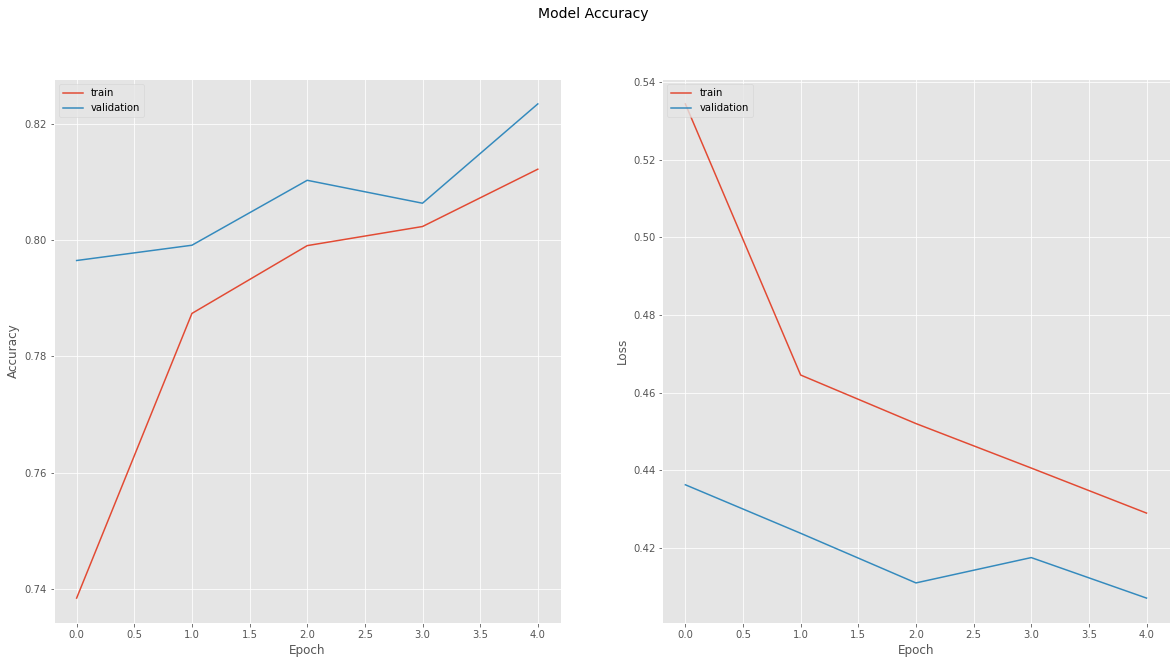

In [33]:
#view model 1 learning curves
plot_learning_curves(history1)

 https://arxiv.org/pdf/1512.05287.pdf

can also implement a callback that automatically halts model training when your performance decreases. This can also serve as grid search for epochs

In [34]:
#define early stopping callback
callback = EarlyStopping(monitor = 'val_loss', patience = 4)

#include it in your models training
#history = model.fit(train, labels, validation_split = .2, epochs = 100, callbacks = [callback])

optimizer to LeakyRelu which allows the model to retain some information about the negative values that propogate through it

 add a fully connected hidden layer after LSTM layer. Will use ReLu activation /orthogonal initialization. 

 https://arxiv.org/pdf/1702.00071.pdf
 https://smerity.com/articles/2016/orthogonal_init.html

In [35]:
#function to create lstm model
def create_lstm_2(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add LSTM layer
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                      kernel_initializer = 'orthogonal'))(emb)
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    x = Dropout(dropout)(x)
    x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              kernel_initializer = 'he_normal'))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [36]:
#define new model
lstm_2 = create_lstm_2(spatial_dropout = .4, dropout = .4, recurrent_dropout = .4,
                       learning_rate = 3e-4, bidirectional = True)

lstm_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 200)      5856000     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_2 (SpatialDro (None, 40, 200)      0           embedding_1[1][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 200)          240800      spatial_dropout1d_2[0][0]        
____________________________________________________________________________________________

In [37]:
#fit model
history2 = lstm_2.fit([nlp_train, meta_train], labels, validation_split = .2,
                       epochs = 30, batch_size = 21, verbose = 1)

Train on 6090 samples, validate on 1523 samples
Epoch 1/30
6090/6090 [==============================] - 44s 7ms/step - loss: 0.6653 - accuracy: 0.6120 - val_loss: 0.5041 - val_accuracy: 0.7754
Epoch 2/30
6090/6090 [==============================] - 43s 7ms/step - loss: 0.5701 - accuracy: 0.7319 - val_loss: 0.4609 - val_accuracy: 0.7951
Epoch 3/30
6090/6090 [==============================] - 43s 7ms/step - loss: 0.5462 - accuracy: 0.7514 - val_loss: 0.4616 - val_accuracy: 0.7997
Epoch 4/30
6090/6090 [==============================] - 43s 7ms/step - loss: 0.5305 - accuracy: 0.7673 - val_loss: 0.4570 - val_accuracy: 0.7958
Epoch 5/30
6090/6090 [==============================] - 43s 7ms/step - loss: 0.5216 - accuracy: 0.7681 - val_loss: 0.4481 - val_accuracy: 0.8089
Epoch 6/30
6090/6090 [==============================] - 43s 7ms/step - loss: 0.5090 - accuracy: 0.7704 - val_loss: 0.4280 - val_accuracy: 0.8188
Epoch 7/30
6090/6090 [==============================] - 43s 7ms/step - loss: 0.500

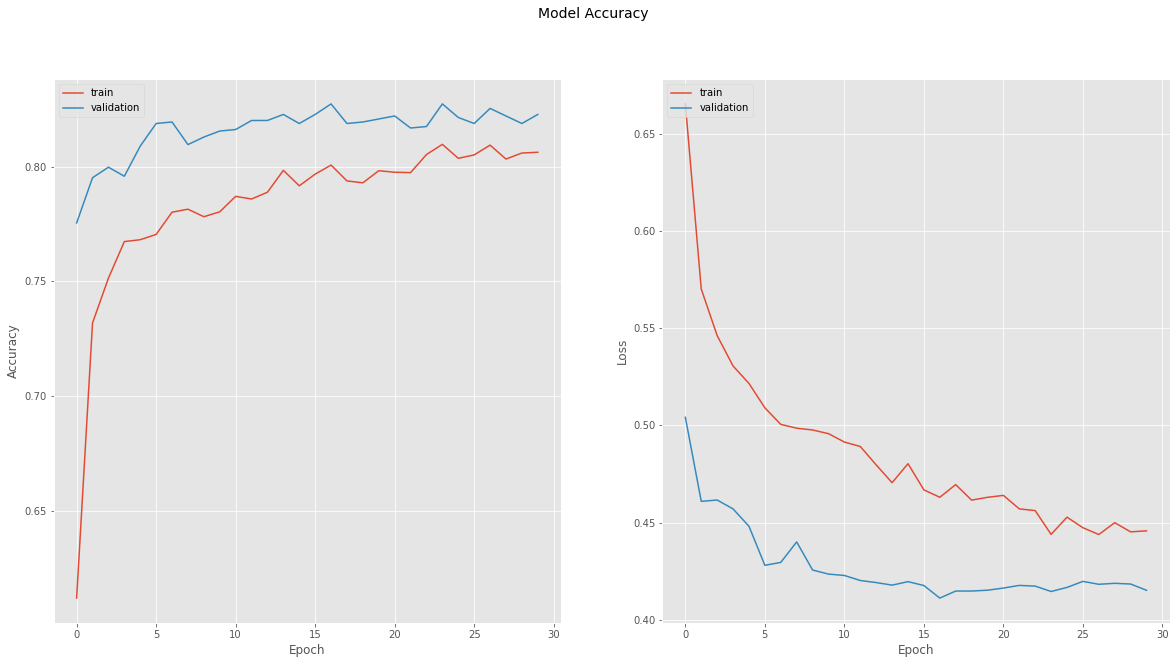

In [38]:
plot_learning_curves(history2)

In [39]:
#create submission for complex lstm model
submission_lstm = pd.DataFrame()
submission_lstm['id'] = test_id
submission_lstm['prob'] = lstm_2.predict([nlp_test, meta_test])
submission_lstm['target'] = submission_lstm['prob'].apply(lambda x: 0 if x < .5 else 1)
submission_lstm.head(10)

,id,prob,target
0,0,0.401771,0
1,2,0.739473,1
2,3,0.787034,1
3,9,0.504873,1
4,11,0.989939,1
5,12,0.415992,0
6,21,0.112830,0
7,22,0.059621,0
8,27,0.061265,0
9,29,0.058091,0


## Dual LSTM Layers

Take the output of one LSTM layer and feed it directly into another LSTM layer. s
Set `return_sequences` = True on the first layer:

In [40]:
#function to create dual lstm model
def create_dual_lstm(spatial_dropout, dropout, recurrent_dropout, learning_rate, bidirectional = False):
    #define activation
    activation = LeakyReLU(alpha = 0.01)
    
    #define inputs
    nlp_input = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'nlp_input')
    meta_input_train = Input(shape = (7, ), name = 'meta_train')
    emb = embedding(nlp_input)
    emb = SpatialDropout1D(dropout)(emb)

    #add dual LSTM layers
    if bidirectional:
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True)))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (Bidirectional(LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal')))(emb)
    else:
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal', return_sequences = True))(emb)
        nlp_out = SpatialDropout1D(dropout)(nlp_out)
        nlp_out = (LSTM(100, dropout = dropout, recurrent_dropout = recurrent_dropout,
                                 kernel_initializer = 'orthogonal'))(emb)
     
     
    #add meta data    
    x = Concatenate()([nlp_out, meta_input_train])
    
    #add second hidden layer
    #x = Dropout(dropout)(x)
    #x = (Dense(100, activation = activation, kernel_regularizer = regularizers.l2(1e-4),
              #kernel_initializer = 'he_normal'))(x)
    
    #add output layer
    x = Dropout(dropout)(x)
    preds = Dense(1, activation='sigmoid', kernel_regularizer = regularizers.l2(1e-4))(x)
    
    #compile model
    model = Model(inputs=[nlp_input , meta_input_train], outputs = preds)
    optimizer = Adam(learning_rate = learning_rate)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    
    return model

In [41]:
#define new model
dual_lstm = create_dual_lstm(spatial_dropout = .4, dropout = .4, recurrent_dropout = .4,
                       learning_rate = 3e-4, bidirectional = True)

dual_lstm.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
nlp_input (InputLayer)          (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 200)      5856000     nlp_input[0][0]                  
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 40, 200)      0           embedding_1[2][0]                
__________________________________________________________________________________________________
bidirectional_4 (Bidirectional) (None, 200)          240800      spatial_dropout1d_3[0][0]        
____________________________________________________________________________________________

In [42]:
history3 = dual_lstm.fit([nlp_train, meta_train], labels, validation_split = .2,
         epochs = 25, batch_size = 21, verbose = 1) #callbacks = [callback]

Train on 6090 samples, validate on 1523 samples
Epoch 1/25
6090/6090 [==============================] - 44s 7ms/step - loss: 0.6033 - accuracy: 0.6732 - val_loss: 0.4777 - val_accuracy: 0.7945
Epoch 2/25
6090/6090 [==============================] - 42s 7ms/step - loss: 0.5306 - accuracy: 0.7481 - val_loss: 0.4603 - val_accuracy: 0.7866
Epoch 3/25
6090/6090 [==============================] - 42s 7ms/step - loss: 0.5089 - accuracy: 0.7619 - val_loss: 0.4459 - val_accuracy: 0.7991
Epoch 4/25
6090/6090 [==============================] - 44s 7ms/step - loss: 0.5015 - accuracy: 0.7668 - val_loss: 0.4235 - val_accuracy: 0.8070
Epoch 5/25
6090/6090 [==============================] - 42s 7ms/step - loss: 0.4813 - accuracy: 0.7778 - val_loss: 0.4331 - val_accuracy: 0.8142
Epoch 6/25
6090/6090 [==============================] - 42s 7ms/step - loss: 0.4769 - accuracy: 0.7826 - val_loss: 0.4186 - val_accuracy: 0.8109
Epoch 7/25
6090/6090 [==============================] - 43s 7ms/step - loss: 0.482

In [43]:
#create submission for complex lstm model
submission_lstm2 = pd.DataFrame()
submission_lstm2['id'] = test_id
submission_lstm2['prob'] = dual_lstm.predict([nlp_test, meta_test])
submission_lstm2['target'] = submission_lstm2['prob'].apply(lambda x: 0 if x < .5 else 1)
submission_lstm2.head(10)

,id,prob,target
0,0,0.465056,0
1,2,0.838753,1
2,3,0.888157,1
3,9,0.542264,1
4,11,0.986302,1
5,12,0.460663,0
6,21,0.110871,0
7,22,0.077938,0
8,27,0.082931,0
9,29,0.082881,0


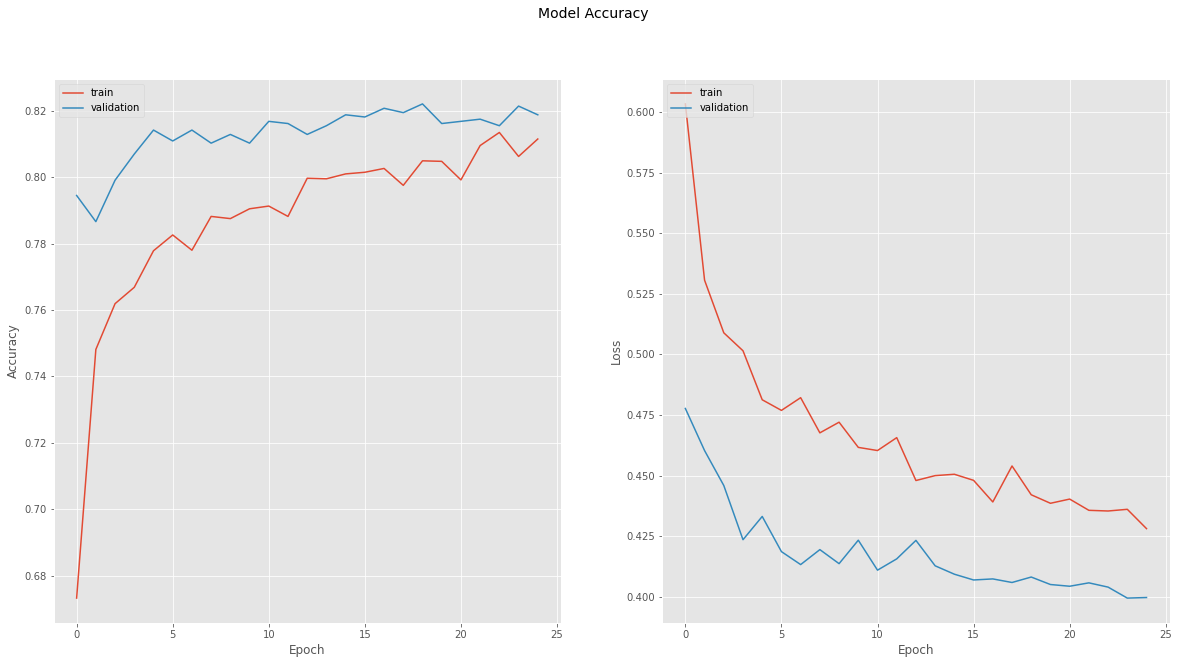

In [44]:
plot_learning_curves(history3)

## BERT

No need to clean our tweets at all, we can just feed them to BERT (after encoding).

HuggingFace Transformers can guess from the name or path of the pretrained model you specify in the `from_pretrained` method. 

AutoModels/Tokenizers
https://huggingface.co/transformers/model_doc/auto.html

In [45]:
#choose batch size
BATCH_SIZE = 32

#how many epochs?
EPOCHS = 2

#use meta data?
USE_META = True

#add dense layer?
ADD_DENSE = False
DENSE_DIM = 64

#add dropout?
ADD_DROPOUT = False
DROPOUT = .2

In [46]:
!pip install --quiet transformers
#import model and Tokenizer
from transformers import TFAutoModel, AutoTokenizer

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [47]:
#BERT
TOKENIZER = AutoTokenizer.from_pretrained("bert-large-uncased")
enc = TOKENIZER.encode("Encode me!")
dec = TOKENIZER.decode(enc)
print("Encode: " + str(enc))
print("Decode: " + str(dec))


Encode: [101, 4372, 16044, 2033, 999, 102]
Decode: [CLS] encode me! [SEP]


In [48]:
def bert_encode(data,maximum_len) :
    input_ids = []
    attention_masks = []
  

    for i in range(len(data.text)):
        encoded = TOKENIZER.encode_plus(data.text[i],
                                        add_special_tokens=True,
                                        max_length=maximum_len,
                                        pad_to_max_length=True,
                                        return_attention_mask=True)
      
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [49]:
def build_model(model_layer, learning_rate, use_meta = USE_META, add_dense = ADD_DENSE,
               dense_dim = DENSE_DIM, add_dropout = ADD_DROPOUT, dropout = DROPOUT):
    
    #define inputs
    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')
    meta_input = tf.keras.Input(shape = (meta_train.shape[1], ))
    
    #insert BERT layer
    transformer_layer = model_layer([input_ids,attention_masks])
    
    #choose only last hidden-state
    output = transformer_layer[1]
    
    #add meta data
    if use_meta:
        output = tf.keras.layers.Concatenate()([output, meta_input])
    
    #add dense relu layer
    if add_dense:
        print("Training with additional dense layer...")
        output = tf.keras.layers.Dense(dense_dim,activation='relu')(output)
    
    #add dropout
    if add_dropout:
        print("Training with dropout...")
        output = tf.keras.layers.Dropout(dropout)(output)
    
    #add final node for binary classification
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)
    
    #assemble and compile
    if use_meta:
        print("Training with meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks, meta_input],outputs = output)
    
    else:
        print("Training without meta-data...")
        model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    model.compile(tf.keras.optimizers.Adam(lr=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [50]:
#reimport train and test since we won't be doing any text cleaning
train = pd.read_csv('../input/nlp-getting-started/train.csv')
test = pd.read_csv('../input/nlp-getting-started/test.csv')

In [51]:
#get BERT layer
bert_large = TFAutoModel.from_pretrained('bert-large-uncased')

#get BERT tokenizer
TOKENIZER = AutoTokenizer.from_pretrained("bert-large-uncased")

#get our inputs
train_input_ids,train_attention_masks = bert_encode(train,60)
test_input_ids,test_attention_masks = bert_encode(test,60)

#debugging step
print('Train length:', len(train_input_ids))
print('Test length:', len(test_input_ids))

#and build and view parameters
BERT_large = build_model(bert_large, learning_rate = 1e-5)
BERT_large.summary()


Train length: 7613
Test length: 3263
Training with meta-data...
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 60, 1024), ( 335141888   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)         

In [52]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('large_model.h5', monitor='val_loss', save_best_only = True, save_weights_only = True)

In [53]:
#train BERT
history_bert = BERT_large.fit([train_input_ids,train_attention_masks, meta_train], train.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)

Epoch 1/2
191/191 [==============================] - 166s 871ms/step - loss: 0.4583 - accuracy: 0.7916 - val_loss: 0.4212 - val_accuracy: 0.8267
Epoch 2/2
191/191 [==============================] - 162s 848ms/step - loss: 0.3455 - accuracy: 0.8634 - val_loss: 0.3812 - val_accuracy: 0.8359


In [54]:
#load model with best losses
BERT_large.load_weights('large_model.h5')

preds_bert = BERT_large.predict([test_input_ids,test_attention_masks,meta_test])

In [55]:
#save as dataframe
submission_bert = pd.DataFrame()
submission_bert['id'] = test_id
submission_bert['prob'] = preds_bert
submission_bert['target'] = np.round(submission_bert['prob']).astype(int)
submission_bert.head(10)

,id,prob,target
0,0,0.954518,1
1,2,0.981542,1
2,3,0.946156,1
3,9,0.990107,1
4,11,0.986582,1
5,12,0.441190,0
6,21,0.121411,0
7,22,0.076994,0
8,27,0.082219,0
9,29,0.089180,0


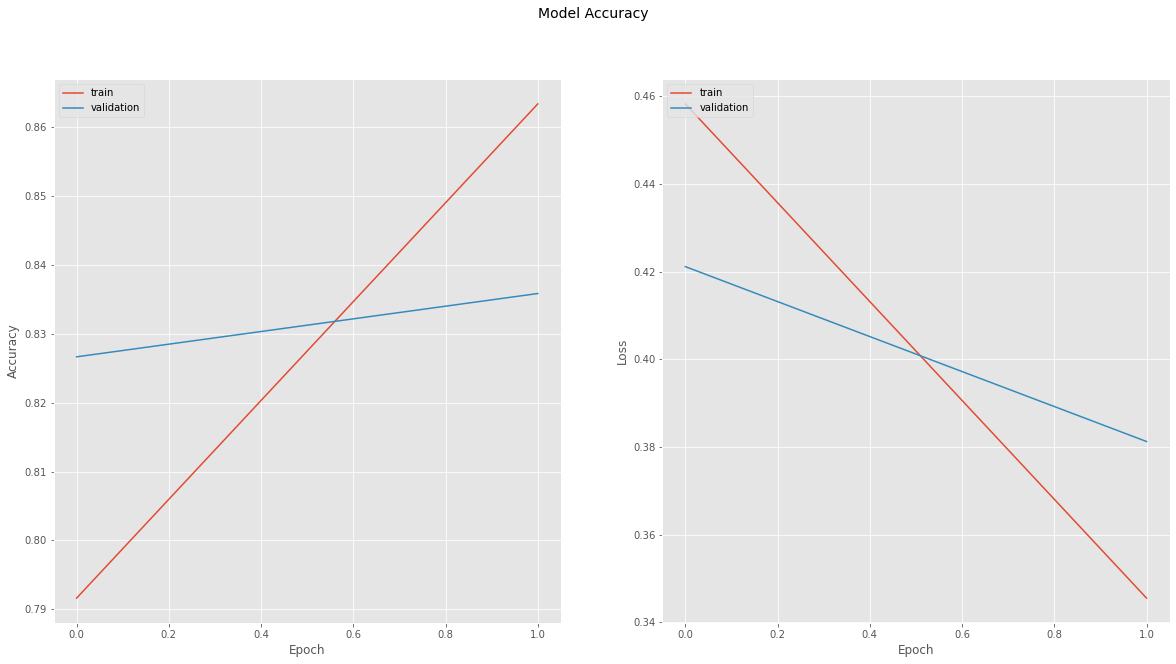

In [57]:
plot_learning_curves(history_bert)

# Tuning Bert

In [58]:
BATCH_SIZE = 16#32
EPOCHS = 2 
USE_META = True
ADD_DENSE = False
DENSE_DIM = 64
ADD_DROPOUT = False
DROPOUT = .2
history_bert2 = BERT_large.fit([train_input_ids,train_attention_masks, meta_train], train.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
BERT_large.load_weights('large_model.h5')
preds_bert = BERT_large.predict([test_input_ids,test_attention_masks,meta_test])

Epoch 1/2
381/381 [==============================] - 172s 451ms/step - loss: 0.3125 - accuracy: 0.8816 - val_loss: 0.4663 - val_accuracy: 0.8175
Epoch 2/2
381/381 [==============================] - 172s 450ms/step - loss: 0.2525 - accuracy: 0.9099 - val_loss: 0.4228 - val_accuracy: 0.8253


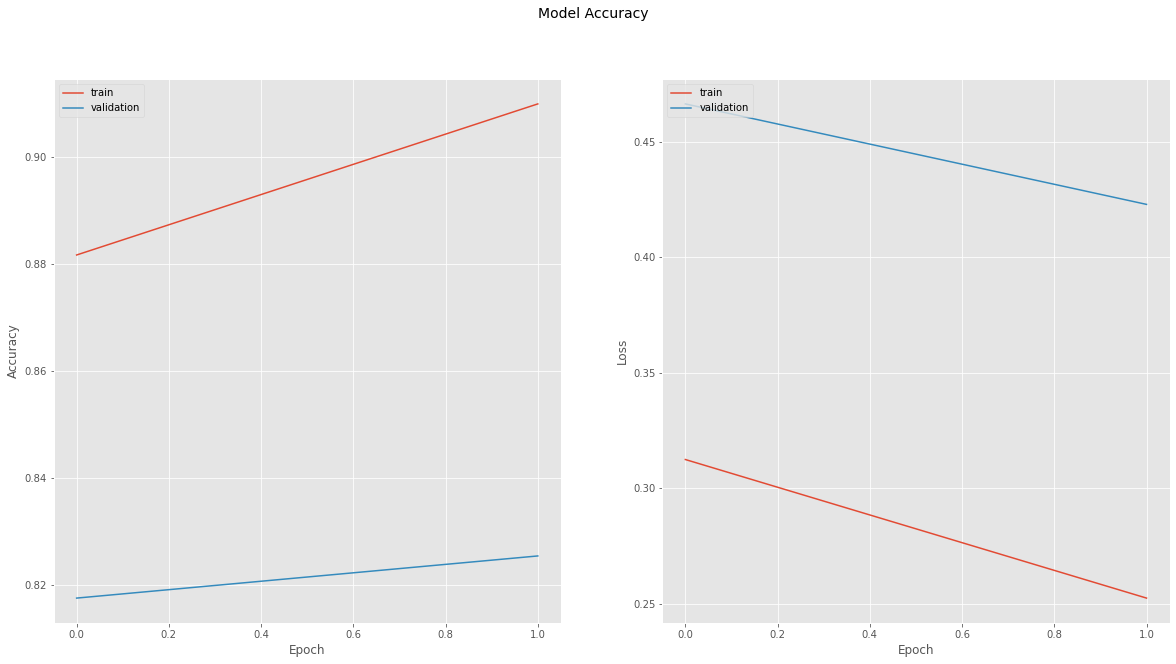

In [59]:
plot_learning_curves(history_bert2)

In [60]:
BATCH_SIZE = 32
EPOCHS = 2
USE_META = True
ADD_DENSE = False
DENSE_DIM = 64
ADD_DROPOUT = True#False
DROPOUT = .2
history_bert3 = BERT_large.fit([train_input_ids,train_attention_masks, meta_train], train.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
BERT_large.load_weights('large_model.h5')
preds_bert = BERT_large.predict([test_input_ids,test_attention_masks,meta_test])

Epoch 1/2
191/191 [==============================] - 159s 831ms/step - loss: 0.2711 - accuracy: 0.8985 - val_loss: 0.4656 - val_accuracy: 0.8332
Epoch 2/2
191/191 [==============================] - 159s 830ms/step - loss: 0.2216 - accuracy: 0.9220 - val_loss: 0.4717 - val_accuracy: 0.8286


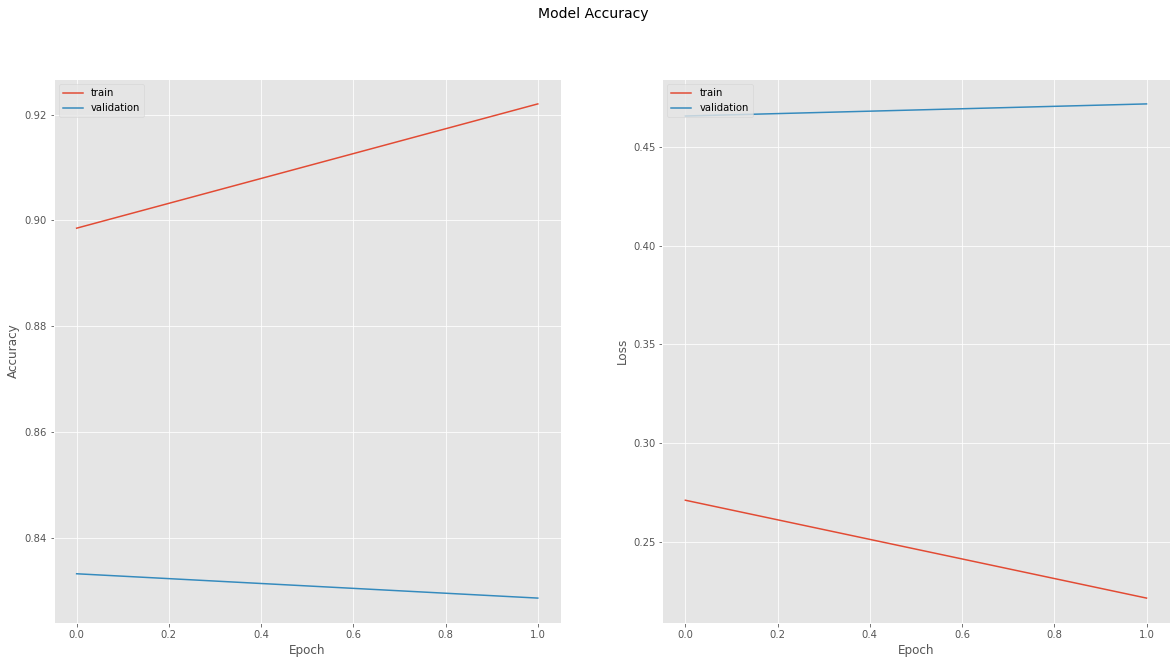

In [61]:
plot_learning_curves(history_bert3)

In [62]:
BATCH_SIZE = 32
EPOCHS = 4#2
USE_META = True
ADD_DENSE = False
DENSE_DIM = 64
ADD_DROPOUT = False
DROPOUT = .2
history_bert4 = BERT_large.fit([train_input_ids,train_attention_masks, meta_train], train.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
BERT_large.load_weights('large_model.h5')
preds_bert = BERT_large.predict([test_input_ids,test_attention_masks,meta_test])

Epoch 1/4
191/191 [==============================] - 159s 831ms/step - loss: 0.2764 - accuracy: 0.8961 - val_loss: 0.4578 - val_accuracy: 0.8372
Epoch 2/4
191/191 [==============================] - 158s 830ms/step - loss: 0.2227 - accuracy: 0.9223 - val_loss: 0.4723 - val_accuracy: 0.8273
Epoch 3/4
191/191 [==============================] - 159s 830ms/step - loss: 0.1907 - accuracy: 0.9360 - val_loss: 0.4978 - val_accuracy: 0.8253
Epoch 4/4
191/191 [==============================] - 159s 830ms/step - loss: 0.1855 - accuracy: 0.9340 - val_loss: 0.5019 - val_accuracy: 0.8332


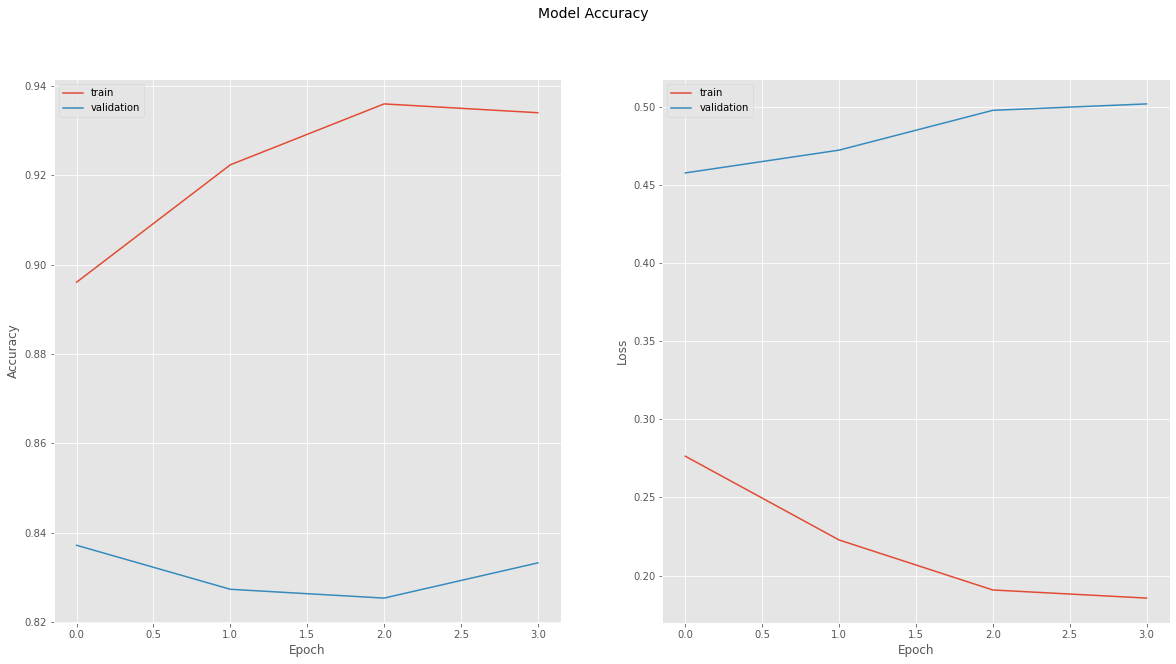

In [63]:
plot_learning_curves(history_bert4)

In [64]:
BATCH_SIZE = 32
EPOCHS = 2
USE_META = True
ADD_DENSE = True#False
DENSE_DIM = 64
ADD_DROPOUT = False
DROPOUT = .2
history_bert5 = BERT_large.fit([train_input_ids,train_attention_masks, meta_train], train.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
BERT_large.load_weights('large_model.h5')
preds_bert = BERT_large.predict([test_input_ids,test_attention_masks,meta_test])

Epoch 1/2
191/191 [==============================] - 159s 830ms/step - loss: 0.2705 - accuracy: 0.8990 - val_loss: 0.4589 - val_accuracy: 0.8345
Epoch 2/2
191/191 [==============================] - 158s 829ms/step - loss: 0.2242 - accuracy: 0.9199 - val_loss: 0.4269 - val_accuracy: 0.8319


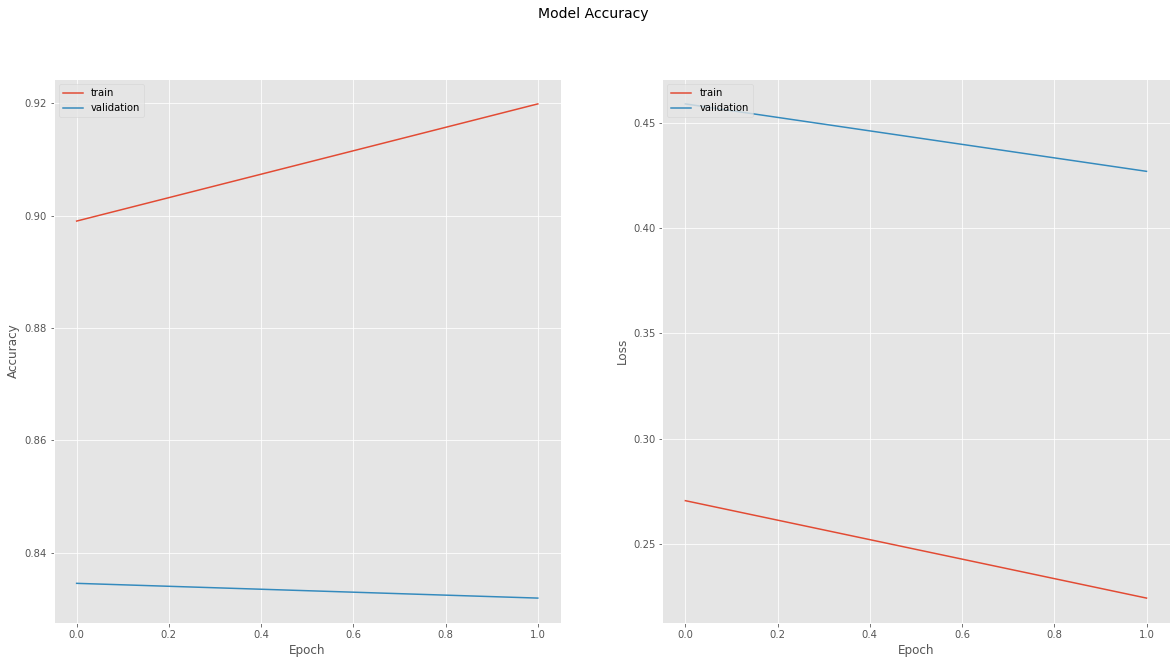

In [65]:
plot_learning_curves(history_bert5)

BATCH_SIZE = 32
EPOCHS = 10#2
USE_META = True
ADD_DENSE = False
DENSE_DIM = 64
ADD_DROPOUT = False
DROPOUT = .2
history_bert6 = BERT_large.fit([train_input_ids,train_attention_masks, meta_train], train.target,
                         validation_split = .2, epochs = EPOCHS, callbacks = [checkpoint], batch_size = BATCH_SIZE)
BERT_large.load_weights('large_model.h5')
preds_bert = BERT_large.predict([test_input_ids,test_attention_masks,meta_test])

plot_learning_curves(history_bert6)

references:

https://www.kaggle.com/code/aishwarya2210/prediction-of-tweets-using-bert-model

https://www.kaggle.com/code/marcovasquez/basic-nlp-with-tensorflow-and-wordcloud

https://www.kaggle.com/code/tuckerarrants/disaster-tweets-eda-glove-rnns-bert

https://www.kaggle.com/code/datafan07/disaster-tweets-nlp-eda-bert-with-transformers